In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import networkx as nx
# fix the seed
np.random.seed(0)

In [2]:
# spacing_factor = 4
# N_side = 33
spacing_factor = 4
N_side = 129
cluster_para = {
    # 'alpha': 120,
    'clusters': {
        0 : {
            'alpha': 120,
            'theta': 0.5,
            'phi': 1.,
            'weight': 0.3
        },
        1 : {
            'alpha': 120,
            'theta': -0.5,
            'phi': 2.,
            'weight': 0.3
        },
        2 : {
            'alpha': 120,
            'theta': 0.5,
            'phi': 3.,
            'weight': 0.2
        },
        3 : {
            'alpha': 120,
            'theta': 0.,
            'phi': 0.,
            'weight': 0.2
        },
    },
}

#### Parameters Initialization

$$
{\bf y} = {\bf C} {\bf \Psi} {\bf h}_s
$$

In [3]:
f_c = 7e9 # carrier frequency
N_x = N_side # number of antennas in x direction
N_y = N_side # number of antennas in y direction
lambda_c = 3e8/f_c # wavelength
k_c = 2*np.pi/lambda_c # wave number
delta = lambda_c/ spacing_factor # antenna spacing

N = int(N_x*N_y) # total number of antennas

L_x = (N_x-1) * delta # length of antenna array in x direction
L_y = (N_y-1) * delta # length of antenna array in y direction

#### wavenumber domain

$$
\xi = \left\{\left(l_x , l_y\right) \mid \left(\frac{2 \pi l_x}{L_x}\right)^2+\left(\frac{2 \pi l_y}{L_y}\right)^2 \leq\left(\frac{2 \pi}{\lambda}\right)^2 \right\}
$$

In [4]:
xi = []
l_x_abs_max = int(L_x / lambda_c)
l_y_abs_max = int(L_y / lambda_c)
print("l_x_abs_max = ", l_x_abs_max)
print("l_y_abs_max = ", l_y_abs_max)

# for start with -l_x_abs_max to l_x_abs_max
for l_x in range(-l_x_abs_max, l_x_abs_max + 1):
    # for start with -l_y_abs_max to l_y_abs_max
    for l_y in range(-l_y_abs_max, l_y_abs_max + 1):
        k_x = 2 * np.pi * l_x / L_x
        k_y = 2 * np.pi * l_y / L_y
        if k_x ** 2 + k_y ** 2 < (2 * np.pi / lambda_c) ** 2:
            xi.append((l_x, l_y))

xi_AD = [] # angular domain index pair

n_x_abs_max = int((N_x - 1) / 2)
n_y_abs_max = int((N_y - 1) / 2)
print("n_x_abs_max = ", n_x_abs_max)
print("n_y_abs_max = ", n_y_abs_max)

# for start with -n_x_abs_max to n_x_abs_max
for n_x in range(-n_x_abs_max, n_x_abs_max + 1): 
    # for start with -n_y_abs_max to n_y_abs_max
    for n_y in range(-n_y_abs_max, n_y_abs_max + 1):
        xi_AD.append((n_x, n_y))

l_x_abs_max =  32
l_y_abs_max =  32
n_x_abs_max =  64
n_y_abs_max =  64


#### From wavenumber to angles

$$
\begin{aligned}
& k_x=k_c \sin \theta \cos \phi \stackrel{\text { yields }}{\longrightarrow} \phi=\operatorname{sgn}\left(k_y\right) \arccos \frac{k_x}{\sqrt{k_x^2+k_y^2}} \\
& k_y=k_c \sin \theta \sin \phi \stackrel{\text { yields }}{\longrightarrow} \theta=\arccos \frac{\sqrt{k_c^2-k_x^2-k_y^2}}{k_c}
\end{aligned}
$$

In [5]:
def from_wavenumber_to_angles(k_x, k_y):
    phi = 0 if np.sqrt(k_x**2 + k_y**2) == 0 else np.sign(k_y) * np.arccos(k_x / np.sqrt(k_x**2 + k_y**2))
    theta = np.arccos(
        np.sqrt(k_c**2 - k_x**2 - k_y**2) / k_c
    )
    return (theta, phi)

#### $\Omega\left( l_x, l_y \right)$

$$
\Omega \left( l_x, l_y \right) = \left\{ {\left(r, \theta, \phi\right)} \mid {\frac{2 \pi l_x}{L_x} \leq k_x \leq \frac{2 \pi\left(l_x+1\right)}{L_x}, \frac{2 \pi l_y}{L_y} \leq k_y \leq \frac{2 \pi\left(l_y+1\right)}{L_y}}, r=1 \right\}
$$

#### Angular Power PDF:

$$
p_i(\theta, \phi)=\frac{\alpha_i}{4 \pi \sinh \alpha_i} \cdot \exp \alpha\left\{\sin \theta \sin \theta_i \cos \left(\phi-\phi_i\right)+\cos \theta \cos \theta_i\right\}
$$

$$
A^2\left(\theta, \phi\right) = \sum_{i\in \left\{1,\dots,N_c\right\}} \omega_i p_i\left(\theta,\phi\right)
$$

In [6]:
cluster_para['cluster_num'] = len(cluster_para['clusters'])

def single_cluster_PDF(theta, phi, theta_cen, phi_cen, alpha):
    amp = alpha / (
        4 * np.pi * np.sinh(alpha)
    )
    exp_func = np.exp(
        alpha * (
            np.sin(theta) * np.sin(theta_cen) * np.cos(phi - phi_cen) + np.cos(theta) * np.cos(theta_cen)
        )
    )
    return amp * exp_func

def single_cluster_PDF_wrt_wavenumber(k_x, k_y, theta_cen, phi_cen, alpha):
    if k_x**2 + k_y**2 > k_c**2:
        return 0
    else:
        (theta, phi) = from_wavenumber_to_angles(k_x, k_y)
        return single_cluster_PDF(
            theta=theta,
            phi=phi,
            theta_cen = theta_cen,
            phi_cen = phi_cen,
            alpha = alpha,
        )   

def multi_cluster_PDF(k_x, k_y, cluster_para):
    (theta, phi) = from_wavenumber_to_angles(k_x, k_y)
    PDF = 0
    for cluster_id in range(cluster_para['cluster_num']):
        PDF += single_cluster_PDF(
            theta=theta,
            phi=phi,
            theta_cen = cluster_para['clusters'][cluster_id]['theta'],
            phi_cen = cluster_para['clusters'][cluster_id]['phi'],
            alpha = cluster_para['clusters'][cluster_id]['alpha'],
        ) * cluster_para['clusters'][cluster_id]['weight']
    return PDF

def multi_cluster_PDF_wrt_wavenumber(k_x, k_y, cluster_para):
    # (theta, phi) = from_wavenumber_to_angles(k_x, k_y)
    PDF = 0
    for cluster_id in range(cluster_para['cluster_num']):
        PDF += single_cluster_PDF_wrt_wavenumber(
            k_x=k_x,
            k_y=k_y,
            theta_cen = cluster_para['clusters'][cluster_id]['theta'],
            phi_cen = cluster_para['clusters'][cluster_id]['phi'],
            alpha = cluster_para['clusters'][cluster_id]['alpha'],
        ) * cluster_para['clusters'][cluster_id]['weight']
    return PDF

def show_multi_cluster_PDF(cluster_para,resolution=100):
    k_x_test = 2 * np.pi / L_x * np.linspace(-l_x_abs_max, l_x_abs_max, resolution)
    k_y_test = 2 * np.pi / L_x * np.linspace(-l_y_abs_max, l_y_abs_max, resolution)
    k_x_mesh, k_y_mesh = np.meshgrid(k_x_test, k_y_test)
    PDF_mesh = np.zeros_like(k_x_mesh)
    for i in range(len(k_x_test)):
        for j in range(len(k_y_test)):
            PDF_mesh[i, j] = multi_cluster_PDF(
                k_x = k_x_test[i],
                k_y = k_y_test[j],
                cluster_para = cluster_para,
            )
    plt.figure(figsize=(8, 8))
    plt.imshow(PDF_mesh, extent=[-l_x_abs_max, l_x_abs_max, -l_y_abs_max, l_y_abs_max])
    plt.colorbar()
    plt.show()

# show_multi_cluster_PDF(cluster_para,resolution=200)

#### Wavenumber Domain Variance

$$
\sigma_f^2\left(l_x, l_y\right) = \iint_{\Omega_R\left(l_x, l_y\right)} A^2(\theta, \phi) \sin \theta \mathrm{d} \theta \mathrm{d} \phi
$$

$$
=\int_{\frac{2 \pi l_y}{L_{R, y}}}^{\frac{2 \pi\left(l_y+1\right)}{L_{R, y}}} \int_{\frac{2 \pi l_x}{L_{R, x}}}^{\frac{2 \pi\left(l_x+1\right)}{L_{R, x}}} \frac{A^2\left(k_x, k_y\right)}{\sqrt{k^2-k_x^2-k_y^2}} d k_x d k_y
$$

In [7]:
def multi_cluster_integral_func(k_x, k_y):
    if k_x**2 + k_y**2 > k_c**2:
        return np.nan
    else:
        res = multi_cluster_PDF(
            k_x=k_x,
            k_y=k_y,
            cluster_para=cluster_para,
        ) / np.sqrt(
            k_c**2 - k_x**2 - k_y**2
        )
        return res

def single_variance(l_x, l_y, resolution=100):
    # integral region
    # k_x from 2*np.pi * l_x/ L_x to 2*np.pi * (l_x+1)/ L_x 
    # k_y from 2*np.pi * l_y/ L_y to 2*np.pi * (l_y+1)/ L_y
    k_x_region = np.linspace(2*np.pi * l_x/ L_x, 2*np.pi * (l_x+1)/ L_x, resolution)
    k_y_region = np.linspace(2*np.pi * l_y/ L_y, 2*np.pi * (l_y+1)/ L_y, resolution)
    
    # mesh grid
    k_mesh = np.meshgrid(k_x_region, k_y_region)
    
    # grid size
    dk = (k_x_region[1] - k_x_region[0]) * (k_y_region[1] - k_y_region[0])
    
    integral_res = 0
    for k_x in k_x_region:
        for k_y in k_y_region:
            integral_res += multi_cluster_integral_func(k_x, k_y)
    
    return integral_res * dk

l_x_grid = np.arange(-l_x_abs_max, l_x_abs_max+1)
l_y_grid = np.arange(-l_y_abs_max, l_y_abs_max+1)
l_mesh = np.meshgrid(l_x_grid, l_y_grid)

variance = np.zeros((2*l_x_abs_max+1, 2*l_y_abs_max+1))

for l_x in range(-l_x_abs_max, l_x_abs_max+1):
    for l_y in range(-l_y_abs_max, l_y_abs_max+1):
        l_x_idx = l_x + l_x_abs_max
        l_y_idx = l_y + l_y_abs_max
        variance[l_x_idx, l_y_idx] = single_variance(l_x, l_y, resolution=10)

# plot

def visualize_wavenumber_variance(variance):
    # plt.figure(figsize=(8, 6))
    plt.imshow(variance, cmap='jet', extent=[-l_x_abs_max, l_x_abs_max, -l_y_abs_max, l_y_abs_max])
    plt.colorbar()
    plt.title('Variance of the channel')
# visualize_wavenumber_variance(variance)

/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32184/3765313644.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  res = multi_cluster_PDF(


#### Dictionary Matrix

$$
[{\bf \Psi}]_{n, l}=\frac{1}{\sqrt{N}} \exp j\left\{\frac{2 \pi l_x}{L_x} \delta \cdot n_x+\frac{2 \pi l_y}{L_y} \delta \cdot n_y\right\}
$$

In [8]:
def Psi_col(l_pair):
    l_x = l_pair[0]
    l_y = l_pair[1]
    amp = 1 / np.sqrt(N)
    exp_func = np.exp(
        1j * (
            2*np.pi * l_x / L_x * delta * (np.arange(N_x) - (N_x - 1) / 2) + \
                2*np.pi * l_y / L_y * delta * (np.arange(N_y) - (N_y - 1) / 2)[:, np.newaxis]
        )
    )
    vec = np.reshape(exp_func, (N_x*N_y, ))
    return amp * vec

# a = Psi_col((1, 1))
# np.shape(a)

xi_norm = len(xi)
Psi = np.zeros((N, xi_norm), dtype=np.complex_)

for l, l_pair in enumerate(xi):
    Psi[:, l] = Psi_col(l_pair)
    # print(l_pair)

$$
\left[ {\bf\Psi}^{a}  \right]_{n, n^\prime} = \frac{1}{\sqrt{N}} \exp j \left\{
    \frac{2\pi n^\prime_x}{N_x}\cdot n_x + \frac{2\pi n^\prime_y}{N_y} \cdot n_y
\right\}
$$

In [9]:
def Psi_AD_col(n_prime_pair):
    n_prime_x = n_prime_pair[0]
    n_prime_y = n_prime_pair[1]
    amp = 1 / np.sqrt(N)
    exp_func = np.exp(
        1j * (
            2*np.pi * n_prime_x / N_x * (np.arange(N_x) - (N_x - 1) / 2) + \
                2*np.pi * n_prime_y / N_y * (np.arange(N_y) - (N_y - 1) / 2)[:, np.newaxis]
        )
    )
    vec = np.reshape(exp_func, (N_x*N_y, ))
    return amp * vec

xi_AD_norm = len(xi_AD)
Psi_AD = np.zeros((N, xi_AD_norm), dtype=np.complex_)
for n_prime, n_prime_pair in enumerate(xi_AD):
    Psi_AD[:, n_prime] = Psi_AD_col(n_prime_pair)
    # print(n_prime_pair)

$$
\left[ {\bf H}_a \right]_{l_x, l_y} \sim \mathcal{CN} \left(0, \sigma_f^2\left(l_x, l_y\right)\right)
$$

In [10]:
vec_sigma_f = np.mat(np.zeros((xi_norm, 1)))
for l, l_pair in enumerate(xi):
    l_x = l_pair[0]
    l_y = l_pair[1]
    vec_sigma_f[l] = variance[l_x + l_x_abs_max, l_y + l_y_abs_max]
    # if nan
    if np.isnan(vec_sigma_f[l]):
        vec_sigma_f[l] = 0

np.random.seed(0)
vec_H_a = np.mat(np.random.normal(0, 1, (xi_norm, 1)) + 1j * np.random.normal(0, 1, (xi_norm, 1)))

# Hadamard product of vec_sigma_f and vec_H_a
vec_H_a = np.multiply(vec_sigma_f, vec_H_a) 


# visualize the channel
def visualize_wavenumber_domain_channel(vec_H_a):
    mat_H_a = np.mat(np.zeros((2*l_x_abs_max+1, 2*l_y_abs_max+1), dtype=complex))
    # all set to np.nan in mat_H_a
    mat_H_a[:,:] = np.nan
    for l, l_pair in enumerate(xi):
        l_x = l_pair[0]
        l_y = l_pair[1]
        mat_H_a[l_x + l_x_abs_max, l_y + l_y_abs_max] = vec_H_a[l]

    # plt.figure(figsize=(10, 10))
    plt.imshow(np.abs(mat_H_a),extent=[-l_x_abs_max, l_x_abs_max, -l_y_abs_max, l_y_abs_max], cmap='hot')
    plt.colorbar()
    return mat_H_a
# visualize_wavenumber_domain_channel(vec_H_a)

$$
{\bf H}\in \mathbb{C}^{N\times 1} = \underbrace{{\bf \Psi}}_{\mathbb{C}^{N \times \left|\xi \right|}} {\rm vec}\left( {\bf H}_a \right)
$$

In [11]:
H_channel = np.zeros((N,1), dtype=np.complex64)
H_channel = Psi * vec_H_a

#### DFT power spectral

In [12]:
def DFT_power_spectrum(H_channel):
    # DFT power spectrum of the channel
    vec_H_DFT = np.reshape(
        np.fft.fft2(np.reshape(H_channel, (N_x, N_y))),
        (-1, 1)
    )
    DFT_power = np.abs(np.fft.fft2(np.reshape(H_channel, (N_x, N_y))))

    # element shift according to the DFT power spectrum
    DFT_power = np.fft.fftshift(DFT_power)
    
    # normalize the DFT power spectrum
    DFT_power = DFT_power / np.max(DFT_power)

    # visualize the DFT power spectrum
    # plt.figure(figsize=(10, 10))
    plt.imshow(DFT_power, cmap='jet', extent=[-np.pi/2, np.pi/2, -np.pi/2, np.pi/2])
    plt.colorbar()
    plt.title('normmalized DFT power spectrum')
    
    return vec_H_DFT
# DFT_power_spectrum(H_channel)

#### From CSI to vec_H_AD

In [13]:
# visualize the angular domain channel
def visualize_angular_domain_channel(vec_H_AD, trim = False):
    mat_H_AD = np.mat(np.zeros((N_x, N_y), dtype=complex))
    # all set to np.nan in mat_H_a
    # mat_H_a[:,:] = np.nan
    for n_prime, n_prime_pair in enumerate(xi_AD):
        n_prime_x = n_prime_pair[0]
        n_prime_y = n_prime_pair[1]
        mat_H_AD[n_prime_x + n_x_abs_max, n_prime_y + n_y_abs_max] = vec_H_AD[n_prime]

    # plt.figure(figsize=(10, 10))
    plt.imshow(np.abs(mat_H_AD), cmap='jet', extent=[- n_x_abs_max, n_x_abs_max, - n_y_abs_max, n_y_abs_max])
    
    # trim the image only show the center part
    if trim:
        plt.xlim(-l_x_abs_max, l_x_abs_max)
        plt.ylim(-l_y_abs_max, l_y_abs_max)
    plt.colorbar()
    return mat_H_AD

vec_H_AD = Psi_AD * H_channel

# visualize_angular_domain_channel(vec_H_AD)

#### Analize Sparseness

In [14]:
def find_real_sparseness(vec_H_a, threshold=0.9):
    vec_H_a_abs = np.abs(vec_H_a)
    M = vec_H_a_abs.shape[0]
    # sort the vector in descending order
    vec_H_a_sorted = np.sort(np.reshape(np.array(vec_H_a_abs), (M,)), )
    vec_H_a_sorted = np.flip(vec_H_a_sorted, axis=0)
    overall_power = np.sum(vec_H_a_sorted)
    
    K = 0
    for i, val in enumerate(vec_H_a_sorted):
        if np.sum(vec_H_a_sorted[0:i]) >= threshold * overall_power:
            K = i
            break
    tau = 0
    if 2 * K >= M:
        tau = vec_H_a_sorted[-1]
    else:
        tau = vec_H_a_sorted[2 * K]
    alpha = vec_H_a_sorted[0]
    sparseness = K / M
    return sparseness

#### Visualize Channel

/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32184/2878257243.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_H_a[l_x + l_x_abs_max, l_y + l_y_abs_max] = vec_H_a[l]
/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32184/4074440541.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_H_AD[n_prime_x + n_x_abs_max, n_prime_y + n_y_abs_max] = vec_H_AD[n_prime]


sparseness =  0.1294851794071763
sparseness =  0.06778438795745448


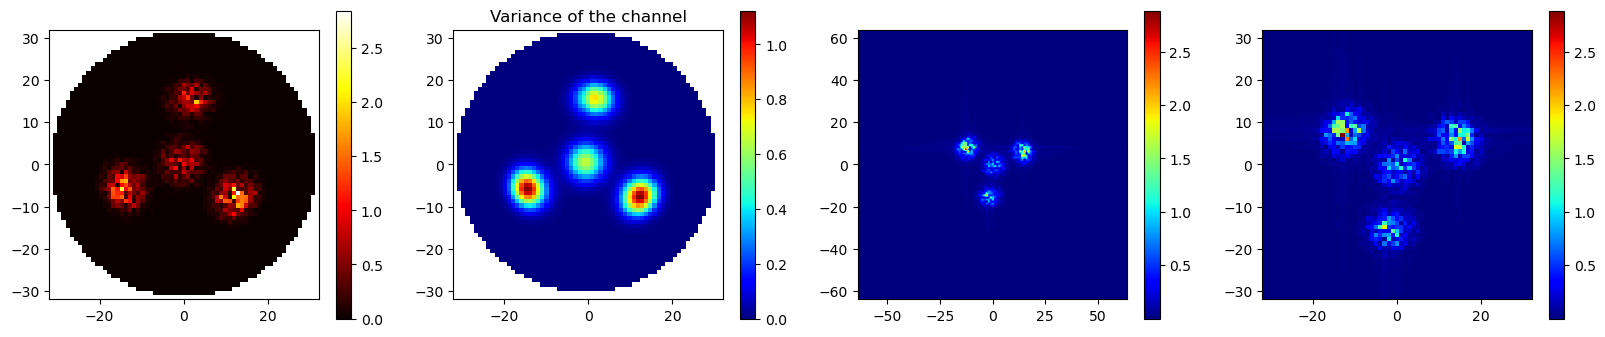

In [15]:
# 1 row 3 columns
plt.figure(figsize=(20, 4))
# sub out of 3 in one row
plt.subplot(141)
visualize_wavenumber_domain_channel(vec_H_a)

plt.subplot(142)
visualize_wavenumber_variance(variance)

plt.subplot(143)
visualize_angular_domain_channel(vec_H_AD)

plt.subplot(144)
visualize_angular_domain_channel(vec_H_AD, trim=True)

# print sparseness
print("sparseness = ", find_real_sparseness(vec_H_a))
print("sparseness = ", find_real_sparseness(vec_H_AD))

#### Save data

/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32184/2878257243.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_H_a[l_x + l_x_abs_max, l_y + l_y_abs_max] = vec_H_a[l]
/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32184/4074440541.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_H_AD[n_prime_x + n_x_abs_max, n_prime_y + n_y_abs_max] = vec_H_AD[n_prime]


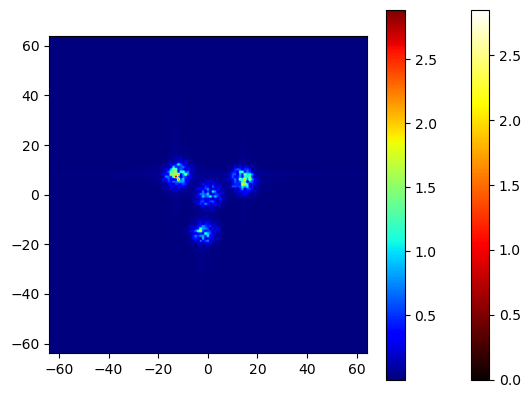

In [16]:
generate_channel_data = {
    'meta_data' :{
        'cluster_para' : cluster_para,
        'xi' : xi,
        'xi_AD' : xi_AD,
        'f_c' : f_c,
        'N_x' : N_x,
        'N_y' : N_y,
        'lambda_c' : lambda_c,
        'delta' : delta,
        'N' : N,
        'L_x' : L_x,
        'L_y' : L_y,
    },
    'channel' : {
        'H_channel' : H_channel,
        'vec_H_a' : vec_H_a,
        'vec_H_AD' : vec_H_AD,
        'variance' : variance,
        'Psi' : Psi,
        # 'Psi_AD' : Psi_AD,
        'WND_2D': visualize_wavenumber_domain_channel(vec_H_a),
        'AD_2D': visualize_angular_domain_channel(vec_H_AD),
    }
}

# save to \generate_channel_data\generate_channel_data.mat
import scipy.io as sio
sio.savemat('data/generate_channel_data.mat', generate_channel_data, format='5', do_compression=True)

In [17]:
len(xi)

3205